# Twitter Sentiment Analysis

In [1]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 24.2 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 116 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 128 kB 745 kB/s eta 0:00:01
     |████████████████████████████████| 69 kB 807 kB/s eta 0:00:01
     |████████████████████████████████| 6.3 MB 773 kB/s eta 0:00:01
     |████████████████████████████████| 547 kB 1.1 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-2.1.0-py3-none-any.whl size=110317 sha256=4be380b0766909625a039d86986f20f59ab111c26586a2774d8b412c090a822e
  Stored in directory: /home/sajjanakash18/.cache/pip/wheels/56/b5/6d/86dbe4f29d4688e5163a8b8c6b740494310040286fca4dc648
Successfully built smart-open
  Attempting uninstall: docutils
    Found existing installation: docutils 0.16
    Uninstalling docutils-0.16:
      Successfully uninstalled docutils-0.16
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully u

In [11]:
!pip install tensorflow --upgrade

Requirement already up-to-date: tensorflow in /home/sajjanakash18/anaconda3/lib/python3.7/site-packages (2.2.0)


In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sajjanakash18/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [23]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 10
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [5]:
#dataset_filename = os.listdir("../input")[0]
#dataset_path = os.path.join("..","input",dataset_filename)
#print("Open file:", dataset_path)
df = pd.read_csv('trained.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [6]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [7]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [8]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [9]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 438 ms, sys: 11.8 ms, total: 450 ms
Wall time: 529 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

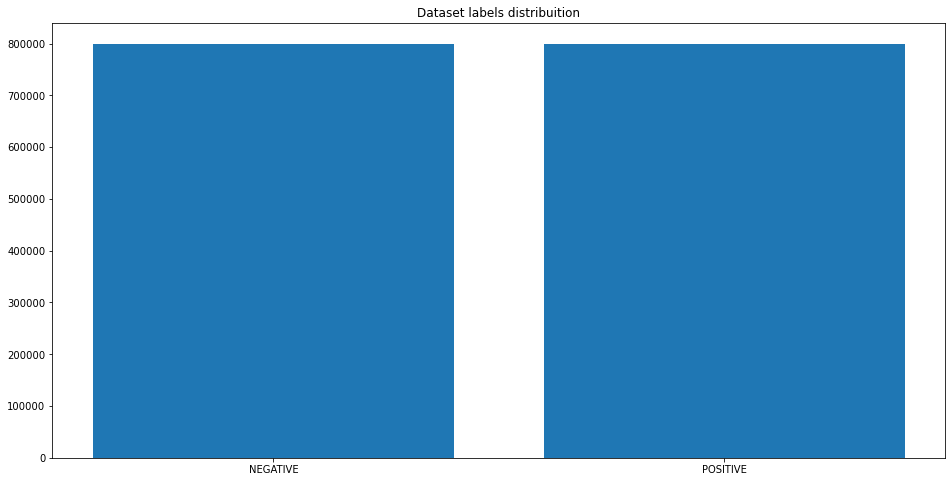

In [10]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [12]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [13]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 46 s, sys: 79.9 ms, total: 46.1 s
Wall time: 46.1 s


### Split train and test

In [14]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [15]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.8 s, sys: 338 ms, total: 3.14 s
Wall time: 22.7 s


In [16]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [17]:
w2v_model.build_vocab(documents)

2020-07-14 18:10:41,140 : INFO : collecting all words and their counts
2020-07-14 18:10:41,141 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-07-14 18:10:41,170 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-07-14 18:10:41,196 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-07-14 18:10:41,212 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-07-14 18:10:41,232 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-07-14 18:10:41,247 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-07-14 18:10:41,263 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-07-14 18:10:41,293 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-07-14 18:10:41,317 : INFO : PROGRESS: at s

2020-07-14 18:10:43,063 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-07-14 18:10:43,096 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-07-14 18:10:43,123 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-07-14 18:10:43,151 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-07-14 18:10:43,187 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-07-14 18:10:43,215 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-07-14 18:10:43,246 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-07-14 18:10:43,271 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-07-14 18:10:43,296 : INFO : PROGRESS: at sentence #800000, processed 577088

In [18]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [19]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-07-14 18:11:06,889 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-07-14 18:11:08,226 : INFO : EPOCH 1 - PROGRESS: at 0.11% examples, 7103 words/s, in_qsize 16, out_qsize 2
2020-07-14 18:11:09,237 : INFO : EPOCH 1 - PROGRESS: at 8.69% examples, 314616 words/s, in_qsize 12, out_qsize 3
2020-07-14 18:11:10,253 : INFO : EPOCH 1 - PROGRESS: at 13.36% examples, 334033 words/s, in_qsize 16, out_qsize 1
2020-07-14 18:11:11,325 : INFO : EPOCH 1 - PROGRESS: at 21.67% examples, 409360 words/s, in_qsize 12, out_qsize 3
2020-07-14 18:11:12,348 : INFO : EPOCH 1 - PROGRESS: at 30.56% examples, 467348 words/s, in_qsize 15, out_qsize 0
2020-07-14 18:11:13,349 : INFO : EPOCH 1 - PROGRESS: at 37.70% examples, 486138 words/s, in_qsize 14, out_qsize 1
2020-07-14 18:11:14,355 : INFO : EPOCH 1 - PROGRESS: at 45.70% examples, 509219 words/s, in_qsize 16, out_qsize 1
2020-07-14 18:11:15,378 : INFO : EPOCH 1 - PROGRESS: at 

2020-07-14 18:11:58,581 : INFO : EPOCH 4 - PROGRESS: at 94.90% examples, 690550 words/s, in_qsize 12, out_qsize 3
2020-07-14 18:11:59,010 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-07-14 18:11:59,015 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-07-14 18:11:59,025 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-07-14 18:11:59,037 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-07-14 18:11:59,050 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-14 18:11:59,053 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-14 18:11:59,054 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-07-14 18:11:59,057 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-14 18:11:59,058 : INFO : EPOCH - 4 : training on 9227204 raw words (8222916 effective words) took 11.8s, 698270 effective words/s
2020-07-14 18:12:00,

2020-07-14 18:12:43,213 : INFO : EPOCH 8 - PROGRESS: at 51.54% examples, 690692 words/s, in_qsize 12, out_qsize 3
2020-07-14 18:12:44,215 : INFO : EPOCH 8 - PROGRESS: at 60.85% examples, 701123 words/s, in_qsize 16, out_qsize 0
2020-07-14 18:12:45,237 : INFO : EPOCH 8 - PROGRESS: at 69.07% examples, 696322 words/s, in_qsize 12, out_qsize 3
2020-07-14 18:12:46,253 : INFO : EPOCH 8 - PROGRESS: at 78.18% examples, 700676 words/s, in_qsize 15, out_qsize 0
2020-07-14 18:12:47,258 : INFO : EPOCH 8 - PROGRESS: at 86.85% examples, 701540 words/s, in_qsize 15, out_qsize 0
2020-07-14 18:12:48,288 : INFO : EPOCH 8 - PROGRESS: at 96.09% examples, 704519 words/s, in_qsize 14, out_qsize 1
2020-07-14 18:12:48,651 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-07-14 18:12:48,654 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-07-14 18:12:48,657 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-07-14 18:12:48,660 : INFO : worker thr

2020-07-14 18:13:28,726 : INFO : EPOCH 12 - PROGRESS: at 33.37% examples, 669359 words/s, in_qsize 14, out_qsize 1
2020-07-14 18:13:29,727 : INFO : EPOCH 12 - PROGRESS: at 42.57% examples, 686536 words/s, in_qsize 16, out_qsize 0
2020-07-14 18:13:30,731 : INFO : EPOCH 12 - PROGRESS: at 51.32% examples, 691750 words/s, in_qsize 15, out_qsize 0
2020-07-14 18:13:31,736 : INFO : EPOCH 12 - PROGRESS: at 60.52% examples, 700597 words/s, in_qsize 16, out_qsize 0
2020-07-14 18:13:32,739 : INFO : EPOCH 12 - PROGRESS: at 69.40% examples, 703936 words/s, in_qsize 14, out_qsize 1
2020-07-14 18:13:33,760 : INFO : EPOCH 12 - PROGRESS: at 78.62% examples, 708155 words/s, in_qsize 16, out_qsize 1
2020-07-14 18:13:34,792 : INFO : EPOCH 12 - PROGRESS: at 87.51% examples, 708060 words/s, in_qsize 16, out_qsize 2
2020-07-14 18:13:35,813 : INFO : EPOCH 12 - PROGRESS: at 96.31% examples, 707861 words/s, in_qsize 16, out_qsize 1
2020-07-14 18:13:36,156 : INFO : worker thread finished; awaiting finish of 7 mo

2020-07-14 18:14:12,922 : INFO : EPOCH 16 - PROGRESS: at 17.24% examples, 692632 words/s, in_qsize 16, out_qsize 1
2020-07-14 18:14:13,976 : INFO : EPOCH 16 - PROGRESS: at 26.45% examples, 701680 words/s, in_qsize 12, out_qsize 3
2020-07-14 18:14:15,014 : INFO : EPOCH 16 - PROGRESS: at 35.86% examples, 712853 words/s, in_qsize 13, out_qsize 2
2020-07-14 18:14:16,027 : INFO : EPOCH 16 - PROGRESS: at 44.18% examples, 705947 words/s, in_qsize 15, out_qsize 0
2020-07-14 18:14:17,059 : INFO : EPOCH 16 - PROGRESS: at 52.95% examples, 704825 words/s, in_qsize 16, out_qsize 0
2020-07-14 18:14:18,063 : INFO : EPOCH 16 - PROGRESS: at 61.28% examples, 701796 words/s, in_qsize 13, out_qsize 2
2020-07-14 18:14:19,077 : INFO : EPOCH 16 - PROGRESS: at 70.16% examples, 704100 words/s, in_qsize 14, out_qsize 1
2020-07-14 18:14:20,101 : INFO : EPOCH 16 - PROGRESS: at 78.84% examples, 703117 words/s, in_qsize 15, out_qsize 0
2020-07-14 18:14:21,122 : INFO : EPOCH 16 - PROGRESS: at 87.62% examples, 703476

2020-07-14 18:14:59,720 : INFO : EPOCH 19 - PROGRESS: at 99.89% examples, 675415 words/s, in_qsize 1, out_qsize 1
2020-07-14 18:14:59,721 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-07-14 18:14:59,732 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-14 18:14:59,733 : INFO : EPOCH - 19 : training on 9227204 raw words (8221973 effective words) took 12.2s, 675457 effective words/s
2020-07-14 18:15:00,748 : INFO : EPOCH 20 - PROGRESS: at 8.26% examples, 675059 words/s, in_qsize 13, out_qsize 2
2020-07-14 18:15:01,760 : INFO : EPOCH 20 - PROGRESS: at 17.46% examples, 711521 words/s, in_qsize 16, out_qsize 0
2020-07-14 18:15:02,773 : INFO : EPOCH 20 - PROGRESS: at 26.23% examples, 711808 words/s, in_qsize 16, out_qsize 1
2020-07-14 18:15:03,785 : INFO : EPOCH 20 - PROGRESS: at 35.32% examples, 718767 words/s, in_qsize 14, out_qsize 1
2020-07-14 18:15:04,801 : INFO : EPOCH 20 - PROGRESS: at 43.86% examples, 713406 words/s, in_qsize 14, out

2020-07-14 18:15:46,110 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-07-14 18:15:46,112 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-07-14 18:15:46,124 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-14 18:15:46,141 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-14 18:15:46,156 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-07-14 18:15:46,162 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-14 18:15:46,163 : INFO : EPOCH - 23 : training on 9227204 raw words (8221994 effective words) took 11.6s, 710750 effective words/s
2020-07-14 18:15:47,196 : INFO : EPOCH 24 - PROGRESS: at 8.69% examples, 701087 words/s, in_qsize 16, out_qsize 0
2020-07-14 18:15:48,197 : INFO : EPOCH 24 - PROGRESS: at 17.78% examples, 723777 words/s, in_qsize 15, out_qsize 0
2020-07-14 18:15:49,213 : INFO : EPOCH 24 - PROGRESS: at 26.78% examples, 725052 words

2020-07-14 18:16:32,060 : INFO : EPOCH 27 - PROGRESS: at 97.07% examples, 715909 words/s, in_qsize 13, out_qsize 2
2020-07-14 18:16:32,294 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-07-14 18:16:32,324 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-07-14 18:16:32,326 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-07-14 18:16:32,336 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-07-14 18:16:32,337 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-14 18:16:32,366 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-14 18:16:32,368 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-07-14 18:16:32,378 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-14 18:16:32,379 : INFO : EPOCH - 27 : training on 9227204 raw words (8223217 effective words) took 11.5s, 717110 effective words/s
2020-07-14 18:16:3

2020-07-14 18:17:15,835 : INFO : EPOCH 31 - PROGRESS: at 70.05% examples, 626479 words/s, in_qsize 16, out_qsize 1
2020-07-14 18:17:16,896 : INFO : EPOCH 31 - PROGRESS: at 78.62% examples, 630265 words/s, in_qsize 16, out_qsize 2
2020-07-14 18:17:17,903 : INFO : EPOCH 31 - PROGRESS: at 86.53% examples, 631635 words/s, in_qsize 15, out_qsize 0
2020-07-14 18:17:18,904 : INFO : EPOCH 31 - PROGRESS: at 94.80% examples, 635239 words/s, in_qsize 15, out_qsize 0
2020-07-14 18:17:19,385 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-07-14 18:17:19,392 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-07-14 18:17:19,416 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-07-14 18:17:19,418 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-07-14 18:17:19,421 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-14 18:17:19,425 : INFO : worker thread finished; awaiting finish of 2 more th

CPU times: user 28min 19s, sys: 7.27 s, total: 28min 27s
Wall time: 6min 25s


(263124181, 295270528)

In [20]:
w2v_model.most_similar("love")

/home/sajjanakash18/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-07-14 18:17:41,592 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5775644183158875),
 ('loves', 0.5497535467147827),
 ('loved', 0.5245630145072937),
 ('adore', 0.5235531330108643),
 ('amazing', 0.5114006400108337),
 ('looove', 0.5092319846153259),
 ('awesome', 0.4804810583591461),
 ('loooove', 0.4620535373687744),
 ('loveee', 0.4535929560661316),
 ('lovee', 0.44046178460121155)]

### Tokenize Text

In [21]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 16.2 s, sys: 92.1 ms, total: 16.3 s
Wall time: 17.5 s


In [24]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 35.8 s, sys: 4.19 s, total: 40 s
Wall time: 8min 58s


### Label Encoder 

In [25]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [26]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [27]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 10)
y_train (1280000, 1)

x_test (320000, 10)
y_test (320000, 1)


In [28]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [29]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [30]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [31]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 300)           87125700  
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [32]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [33]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [34]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - ETA: 0s - loss: 0.5094 - accuracy: 0.7463WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-07-14 18:43:44,321 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 219s 195ms/step - loss: 0.5094 - accuracy: 0.7463 - val_loss: 0.4718 - val_accuracy: 0.7735 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4858 - accuracy: 0.7625WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-07-14 18:47:23,670 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 219s 195ms/step - loss: 0.4858 - accuracy: 0.7625 - val_loss: 0.4656 - val_accuracy: 0.7789 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4791 - accuracy: 0.7671WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-07-14 18:51:00,155 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 216s 192ms/step - loss: 0.4791 - accuracy: 0.7671 - val_loss: 0.4623 - val_accuracy: 0.7799 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4758 - accuracy: 0.7685WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-07-14 18:54:37,102 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 217s 193ms/step - loss: 0.4758 - accuracy: 0.7685 - val_loss: 0.4598 - val_accuracy: 0.7821 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4735 - accuracy: 0.7702WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-07-14 18:58:18,220 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 221s 196ms/step - loss: 0.4735 - accuracy: 0.7702 - val_loss: 0.4568 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4713 - accuracy: 0.7717WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-07-14 19:01:55,645 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 217s 193ms/step - loss: 0.4713 - accuracy: 0.7717 - val_loss: 0.4555 - val_accuracy: 0.7843 - lr: 0.0010
Epoch 7/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4704 - accuracy: 0.7722WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-07-14 19:05:33,004 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 217s 193ms/step - loss: 0.4704 - accuracy: 0.7722 - val_loss: 0.4550 - val_accuracy: 0.7842 - lr: 0.0010
Epoch 8/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4692 - accuracy: 0.7730WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-07-14 19:09:12,549 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 219s 195ms/step - loss: 0.4692 - accuracy: 0.7730 - val_loss: 0.4555 - val_accuracy: 0.7856 - lr: 0.0010
CPU times: user 3h 25min 6s, sys: 3min 41s, total: 3h 28min 48s
Wall time: 29min 15s


### Evaluate

In [35]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 13s 42ms/step - loss: 0.4529 - accuracy: 0.7866

ACCURACY: 0.7865781188011169
LOSS: 0.4529111385345459
CPU times: user 1min 16s, sys: 2.05 s, total: 1min 18s
Wall time: 13.6 s


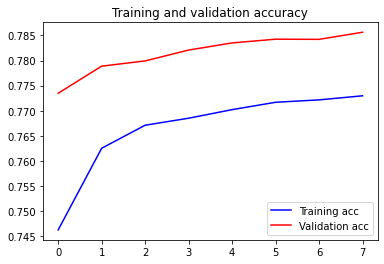

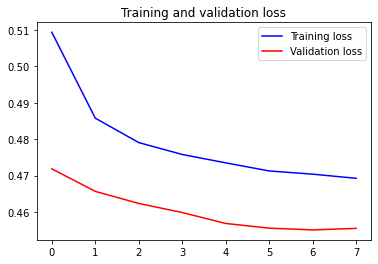

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [40]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [41]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    tokenizer = Tokenizer(num_words=3000)
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [42]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.978448748588562,
 'elapsed_time': 0.2895476818084717}

In [43]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.01063478086143732,
 'elapsed_time': 0.03229236602783203}

In [44]:
predict("i don't know what i'm doing")

{'label': 'NEGATIVE',
 'score': 0.3732438087463379,
 'elapsed_time': 0.031824350357055664}

### Confusion Matrix

In [45]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 12s 307ms/step
CPU times: user 1min 14s, sys: 7.35 s, total: 1min 21s
Wall time: 14.3 s


In [46]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

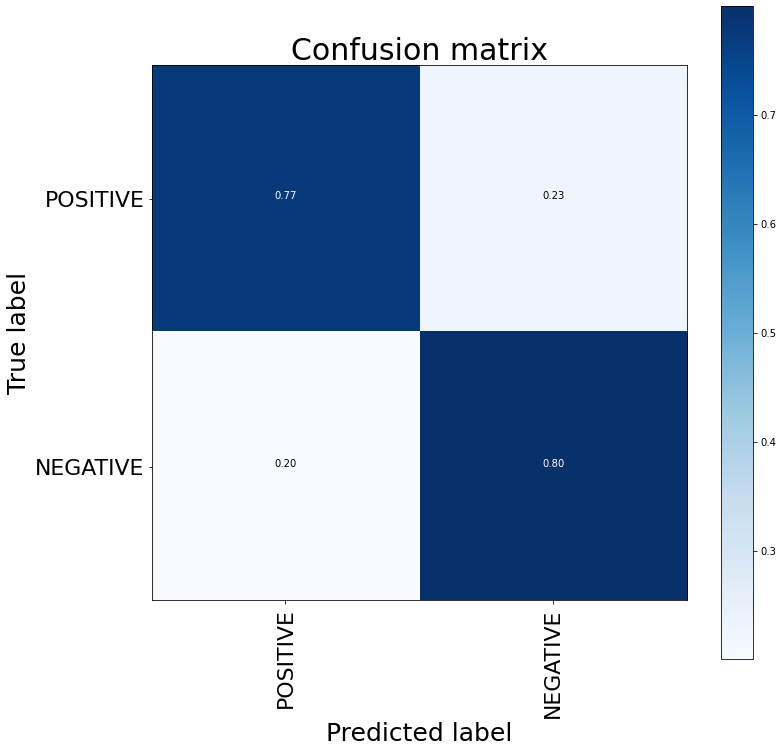

CPU times: user 1.08 s, sys: 20.3 ms, total: 1.1 s
Wall time: 2.06 s


In [47]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [48]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.77      0.78    159494
    POSITIVE       0.78      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



### Accuracy Score

In [49]:
accuracy_score(y_test_1d, y_pred_1d)

0.786578125

### Save model

In [50]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-07-14 19:14:05,792 : INFO : saving Word2Vec object under model.w2v, separately None
2020-07-14 19:14:06,640 : INFO : not storing attribute vectors_norm
2020-07-14 19:14:06,680 : INFO : not storing attribute cum_table
2020-07-14 19:15:08,956 : INFO : saved model.w2v
